In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-10-31 00:44:59.890831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 00:44:59.896050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 00:44:59.896375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps according to the reference paper

In [15]:
def trainPreprocessA(img, lab):
        
        img = tf.image.random_crop(img, [CROP_HEIGHT, CROP_WIDTH, 3])
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        img = tf.clip_by_value(img, 0.0, 255.0)
        
        return img, lab

In [16]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [17]:
def extractGenderLabel(img, lab):
    
    lab = lab['gender']
    
    return img, lab

In [18]:
def extractAgeLabel(img, lab):
    
    lab = lab['age']
    
    return img, lab

### Generate Folds for K-Folds validation

In [19]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [20]:
trainPreBatch = [("train_process_a", trainPreprocessA), 
                 ("train_extract_gender", extractGenderLabel)]

valPreBatch = [("val_process_a", valPreprocessA), 
               ("val_extract_gender", extractGenderLabel)]

In [21]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-10-31 00:45:00.141603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 00:45:00.142384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 00:45:00.142754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 00:45:00.143059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [22]:
len(folds)

5

### Check data

In [23]:
for x,y in folds[0][0].take(1):
    pass

In [24]:
x

<tf.Tensor: shape=(4, 227, 227, 3), dtype=float32, numpy=
array([[[[215.59799 , 214.5353  , 208.08212 ],
         [215.59799 , 214.5353  , 208.08212 ],
         [215.59799 , 214.5353  , 208.08212 ],
         ...,
         [189.88243 , 193.68535 , 179.32556 ],
         [191.49722 , 195.30014 , 182.15675 ],
         [190.91129 , 194.71422 , 181.57083 ]],

        [[214.04675 , 214.5353  , 207.65448 ],
         [213.72305 , 214.5353  , 207.65448 ],
         [214.7427  , 214.5353  , 207.65448 ],
         ...,
         [189.59229 , 193.3952  , 179.03542 ],
         [189.0215  , 192.82443 , 179.68103 ],
         [191.03394 , 194.83687 , 181.69348 ]],

        [[213.74487 , 214.5353  , 208.05362 ],
         [213.76389 , 214.5353  , 208.05362 ],
         [214.96127 , 214.5353  , 208.05362 ],
         ...,
         [190.93742 , 194.74036 , 180.38055 ],
         [187.21931 , 191.02225 , 177.87885 ],
         [190.47385 , 194.27678 , 181.13339 ]],

        ...,

        [[181.50836 , 187.1359  , 

In [25]:
y

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)>

<IPython.core.display.Javascript object>


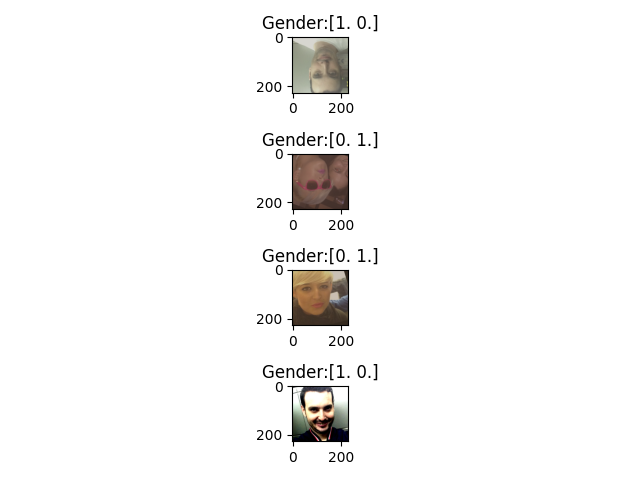

In [26]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y[i]}")
        
plt.tight_layout()

### Model

In [27]:
def createModel():
    inp = tf.keras.Input(shape=(CROP_HEIGHT, CROP_WIDTH, 3))

    backbone = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, input_shape=(CROP_HEIGHT, CROP_WIDTH, 3))
    backbone.trainable = False    
    
    flat1 = tf.keras.layers.Flatten(name='flat1')
    fc1 = tf.keras.layers.Dense(128, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='fc2')

    o = tf.keras.applications.resnet_v2.preprocess_input(inp)
    o = backbone(o, training=False)
    o = flat1(o)
    o = fc1(o)
    o = do1(o)

    o = fc2(o)

    model = tf.keras.models.Model(inputs=inp, outputs=o, name='baseline_1')
    
    return model

In [28]:
model = createModel()

In [29]:
model.summary()

Model: "baseline_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 227, 227, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 227, 227, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 flat1 (Flatten)             (None, 131072)            0         
                                                                 
 fc1 (Dense)                 (None, 128)               1

### Compile Model

In [30]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [31]:
def schedule(epoch, lr):
    return lr

In [32]:
logBasePath = "log/baseline_resnet_5"
logPrefix = "log"

In [33]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel()
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
    loss = tf.keras.losses.CategoricalCrossentropy()
    metrics = ['accuracy']
    
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-10-31 00:45:04.541722: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-10-31 00:45:04.541745: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-10-31 00:45:04.541771: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-10-31 00:45:04.647482: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-10-31 00:45:04.648709: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-10-31 00:45:05.755978: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


  20/3528 [..............................] - ETA: 29s - loss: 1.0214 - accuracy: 0.5625  

2022-10-31 00:45:06.755929: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3528/3528 [==============================] - 29s 8ms/step - loss: 1.1202 - accuracy: 0.5413
Epoch 1/300
   1/1000 [..............................] - ETA: 22:47 - loss: 0.5241 - accuracy: 0.5000

2022-10-31 00:45:35.168663: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-10-31 00:45:35.168686: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


  10/1000 [..............................] - ETA: 1:09 - loss: 1.8430 - accuracy: 0.5500

2022-10-31 00:45:35.621347: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-31 00:45:35.622158: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-10-31 00:45:35.661057: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 3120 callback api events and 3095 activity events. 
2022-10-31 00:45:35.686015: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-10-31 00:45:35.714215: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/baseline_resnet_5/log_0/plugins/profile/2022_10_31_00_45_35

2022-10-31 00:45:35.747403: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/baseline_resnet_5/log_0/plugins/profile/2022_10_31_00_45_35/rachanon-pc1.trace.json.gz
2022-10-31 00:45:35.784565: I tensorflow/core/profiler/rpc/client/save_profile.cc:136]

 999/1000 [============================>.] - ETA: 0s - loss: 0.6133 - accuracy: 0.7988

2022-10-31 00:46:09.869807: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4026531840 exceeds 10% of free system memory.


1000/1000 [==============================] - 37s 36ms/step - loss: 0.6128 - accuracy: 0.7990 - val_loss: 0.5369 - val_accuracy: 0.7737
Epoch 2/300
 994/1000 [============================>.] - ETA: 0s - loss: 0.4388 - accuracy: 0.8187

2022-10-31 00:46:44.693746: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4026531840 exceeds 10% of free system memory.


1000/1000 [==============================] - 35s 35ms/step - loss: 0.4388 - accuracy: 0.8180 - val_loss: 0.4418 - val_accuracy: 0.7952
Epoch 3/300
 998/1000 [============================>.] - ETA: 0s - loss: 0.4042 - accuracy: 0.8176

2022-10-31 00:47:19.421975: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4026531840 exceeds 10% of free system memory.


1000/1000 [==============================] - 35s 35ms/step - loss: 0.4047 - accuracy: 0.8177 - val_loss: 0.3379 - val_accuracy: 0.8520
Epoch 4/300
 996/1000 [============================>.] - ETA: 0s - loss: 0.3905 - accuracy: 0.8316

2022-10-31 00:47:54.555619: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4026531840 exceeds 10% of free system memory.


1000/1000 [==============================] - 35s 35ms/step - loss: 0.3903 - accuracy: 0.8315 - val_loss: 0.3483 - val_accuracy: 0.8464
Epoch 5/300
 997/1000 [============================>.] - ETA: 0s - loss: 0.3646 - accuracy: 0.8438

2022-10-31 00:48:29.390888: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4026531840 exceeds 10% of free system memory.


1000/1000 [==============================] - 35s 35ms/step - loss: 0.3648 - accuracy: 0.8438 - val_loss: 0.3217 - val_accuracy: 0.8551
Epoch 6/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.3392 - accuracy: 0.8602 - val_loss: 0.3536 - val_accuracy: 0.8380
Epoch 7/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.3838 - accuracy: 0.8275 - val_loss: 0.2886 - val_accuracy: 0.8795
Epoch 8/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.3314 - accuracy: 0.8610 - val_loss: 0.2837 - val_accuracy: 0.8781
Epoch 9/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.3302 - accuracy: 0.8612 - val_loss: 0.2869 - val_accuracy: 0.8746
Epoch 10/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.3430 - accuracy: 0.8515 - val_loss: 0.2979 - val_accuracy: 0.8748
Epoch 11/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.3360 - accuracy: 0.8518 - val_loss: 0.2720 - va

1000/1000 [==============================] - 35s 35ms/step - loss: 0.2391 - accuracy: 0.9075 - val_loss: 0.1587 - val_accuracy: 0.9371
Epoch 61/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1855 - accuracy: 0.9312 - val_loss: 0.1524 - val_accuracy: 0.9399
Epoch 62/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.2179 - accuracy: 0.9185 - val_loss: 0.1592 - val_accuracy: 0.9386
Epoch 63/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.2291 - accuracy: 0.9078 - val_loss: 0.1640 - val_accuracy: 0.9343
Epoch 64/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1913 - accuracy: 0.9227 - val_loss: 0.1525 - val_accuracy: 0.9414
Epoch 65/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.2192 - accuracy: 0.9147 - val_loss: 0.1984 - val_accuracy: 0.9205
Epoch 66/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.2069 - accuracy: 0.9210 - val_loss: 0.1766 

1000/1000 [==============================] - 35s 35ms/step - loss: 0.1716 - accuracy: 0.9370 - val_loss: 0.1274 - val_accuracy: 0.9508
Epoch 116/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1947 - accuracy: 0.9225 - val_loss: 0.1087 - val_accuracy: 0.9604
Epoch 117/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1635 - accuracy: 0.9390 - val_loss: 0.1086 - val_accuracy: 0.9591
Epoch 118/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1620 - accuracy: 0.9337 - val_loss: 0.1231 - val_accuracy: 0.9529
Epoch 119/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1620 - accuracy: 0.9370 - val_loss: 0.1216 - val_accuracy: 0.9524
Epoch 120/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.2048 - accuracy: 0.9222 - val_loss: 0.1194 - val_accuracy: 0.9561
Epoch 121/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1614 - accuracy: 0.9392 - val_loss: 0

1000/1000 [==============================] - 35s 35ms/step - loss: 0.1601 - accuracy: 0.9427 - val_loss: 0.0910 - val_accuracy: 0.9674
Epoch 171/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1392 - accuracy: 0.9463 - val_loss: 0.0880 - val_accuracy: 0.9675
Epoch 172/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1612 - accuracy: 0.9398 - val_loss: 0.0826 - val_accuracy: 0.9715
Epoch 173/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1654 - accuracy: 0.9383 - val_loss: 0.0839 - val_accuracy: 0.9695
Epoch 174/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1631 - accuracy: 0.9440 - val_loss: 0.1154 - val_accuracy: 0.9534
Epoch 175/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1442 - accuracy: 0.9467 - val_loss: 0.1210 - val_accuracy: 0.9524
Epoch 176/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1412 - accuracy: 0.9450 - val_loss: 0

1000/1000 [==============================] - 35s 35ms/step - loss: 0.1391 - accuracy: 0.9513 - val_loss: 0.0693 - val_accuracy: 0.9749
Epoch 226/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1365 - accuracy: 0.9530 - val_loss: 0.0711 - val_accuracy: 0.9739
Epoch 227/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1526 - accuracy: 0.9457 - val_loss: 0.0642 - val_accuracy: 0.9782
Epoch 228/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1328 - accuracy: 0.9523 - val_loss: 0.0742 - val_accuracy: 0.9733
Epoch 229/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1413 - accuracy: 0.9463 - val_loss: 0.0686 - val_accuracy: 0.9758
Epoch 230/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1307 - accuracy: 0.9530 - val_loss: 0.0731 - val_accuracy: 0.9746
Epoch 231/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1365 - accuracy: 0.9525 - val_loss: 0

1000/1000 [==============================] - 36s 36ms/step - loss: 0.1335 - accuracy: 0.9520 - val_loss: 0.0741 - val_accuracy: 0.9745
Epoch 281/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1294 - accuracy: 0.9557 - val_loss: 0.0607 - val_accuracy: 0.9787
Epoch 282/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1419 - accuracy: 0.9488 - val_loss: 0.0820 - val_accuracy: 0.9722
Epoch 283/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1531 - accuracy: 0.9523 - val_loss: 0.0563 - val_accuracy: 0.9814
Epoch 284/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1216 - accuracy: 0.9535 - val_loss: 0.1004 - val_accuracy: 0.9639
Epoch 285/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1527 - accuracy: 0.9438 - val_loss: 0.0601 - val_accuracy: 0.9816
Epoch 286/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.1249 - accuracy: 0.9555 - val_loss: 0